<a href="https://colab.research.google.com/github/AMerrington/sense-hackathon/blob/leopauly/SENSE_CDT_Practical_Session_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Description
print('Automated Sentinel-1 Ice, Water, Land Segmentation Challenge')
print('Model training for patche classification')

Automated Sentinel-1 Ice, Water, Land Segmentation Challenge
Model training for patche classification


In [ ]:
## Imports
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import keras
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
## Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Setting variables
SAMPLING_DIR ='/content/drive/MyDrive/png_samples_100x100/' #'/content/drive/MyDrive/png_samples_200x200/' 
META_DIR ='/content/drive/MyDrive/meta3_100x100.npy' #'/content/drive/MyDrive/tiff_sample_metadata/meta3.npy'
SAV_DIR='/content/drive/MyDrive/PolarNet/'
TRAIN_SIZE = 0.7
VALID_SIZE = 1.0 - TRAIN_SIZE
LABELS = {"L": 0,"W": 1,"I": 2,}
n_classes=3
total_samples=6403#6403# 2513 # Change to 2513 for final training
test_size=.1


In [ ]:
## Checking dataset in drive
print('Patches details:')
print('Number of image files (patches)',np.shape(os.listdir(SAMPLING_DIR)))
#print(os.listdir(SAMPLING_DIR))
print('\nMetafile details:')
meta=np.load(META_DIR)
print('Meta file size:',np.shape(meta))
#print('patch ID:',[row[0] for row in meta])
#print('x_cord:',[row[1] for row in meta])
#print('y_cord:',[row[2] for row in meta])
#print('labels:',[LABELS[row[3]] for row in meta])

Patches details:
Number of image files (patches) (6403,)

Metafile details:
Meta file size: (6403, 4)


In [ ]:
## Loading dataset from drive
x=[]
x_list=[row[0] for row in meta]
for index in range(total_samples):
  x.append(np.array(Image.open(SAMPLING_DIR + str(x_list[index]) + ".png")))
x=np.array(x)
#print('image IDs in x:',x_list)

y_=np.array([LABELS[row[3]] for row in meta])
y=y_[:total_samples]
#print('labels in y:',y)


print('Datasets(x,y) loaded from disk')
print('Checking shapes x,y:',np.shape(x),np.shape(y))

Datasets(x,y) loaded from disk
Checking shapes x,y: (6403, 100, 100, 3) (6403,)


In [ ]:
print('No: smaples in Class Land:',np.count_nonzero(y == 0),'(',round(np.count_nonzero(y == 0)/len(y)*100,2),'%)')
print('No: smaples in Class Water:',np.count_nonzero(y == 1),'(',round(np.count_nonzero(y == 1)/len(y)*100,2),'%)')
print('No: smaples in Class Ice:',np.count_nonzero(y == 2),'(',round(np.count_nonzero(y == 2)/len(y)*100,2),'%)')

No: smaples in Class Land: 533 ( 8.32 %)
No: smaples in Class Water: 2989 ( 46.68 %)
No: smaples in Class Ice: 2881 ( 44.99 %)


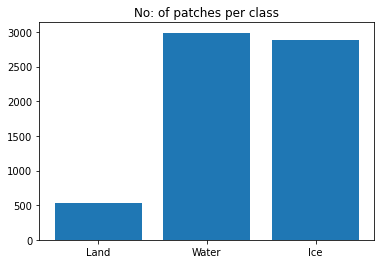

In [ ]:
plt.bar([0,1,2],[np.count_nonzero(y == 0),np.count_nonzero(y == 1),np.count_nonzero(y == 2)])
plt.xticks([0,1,2], ('Land', 'Water', 'Ice'))
plt.title('No: of patches per class')
plt.show()

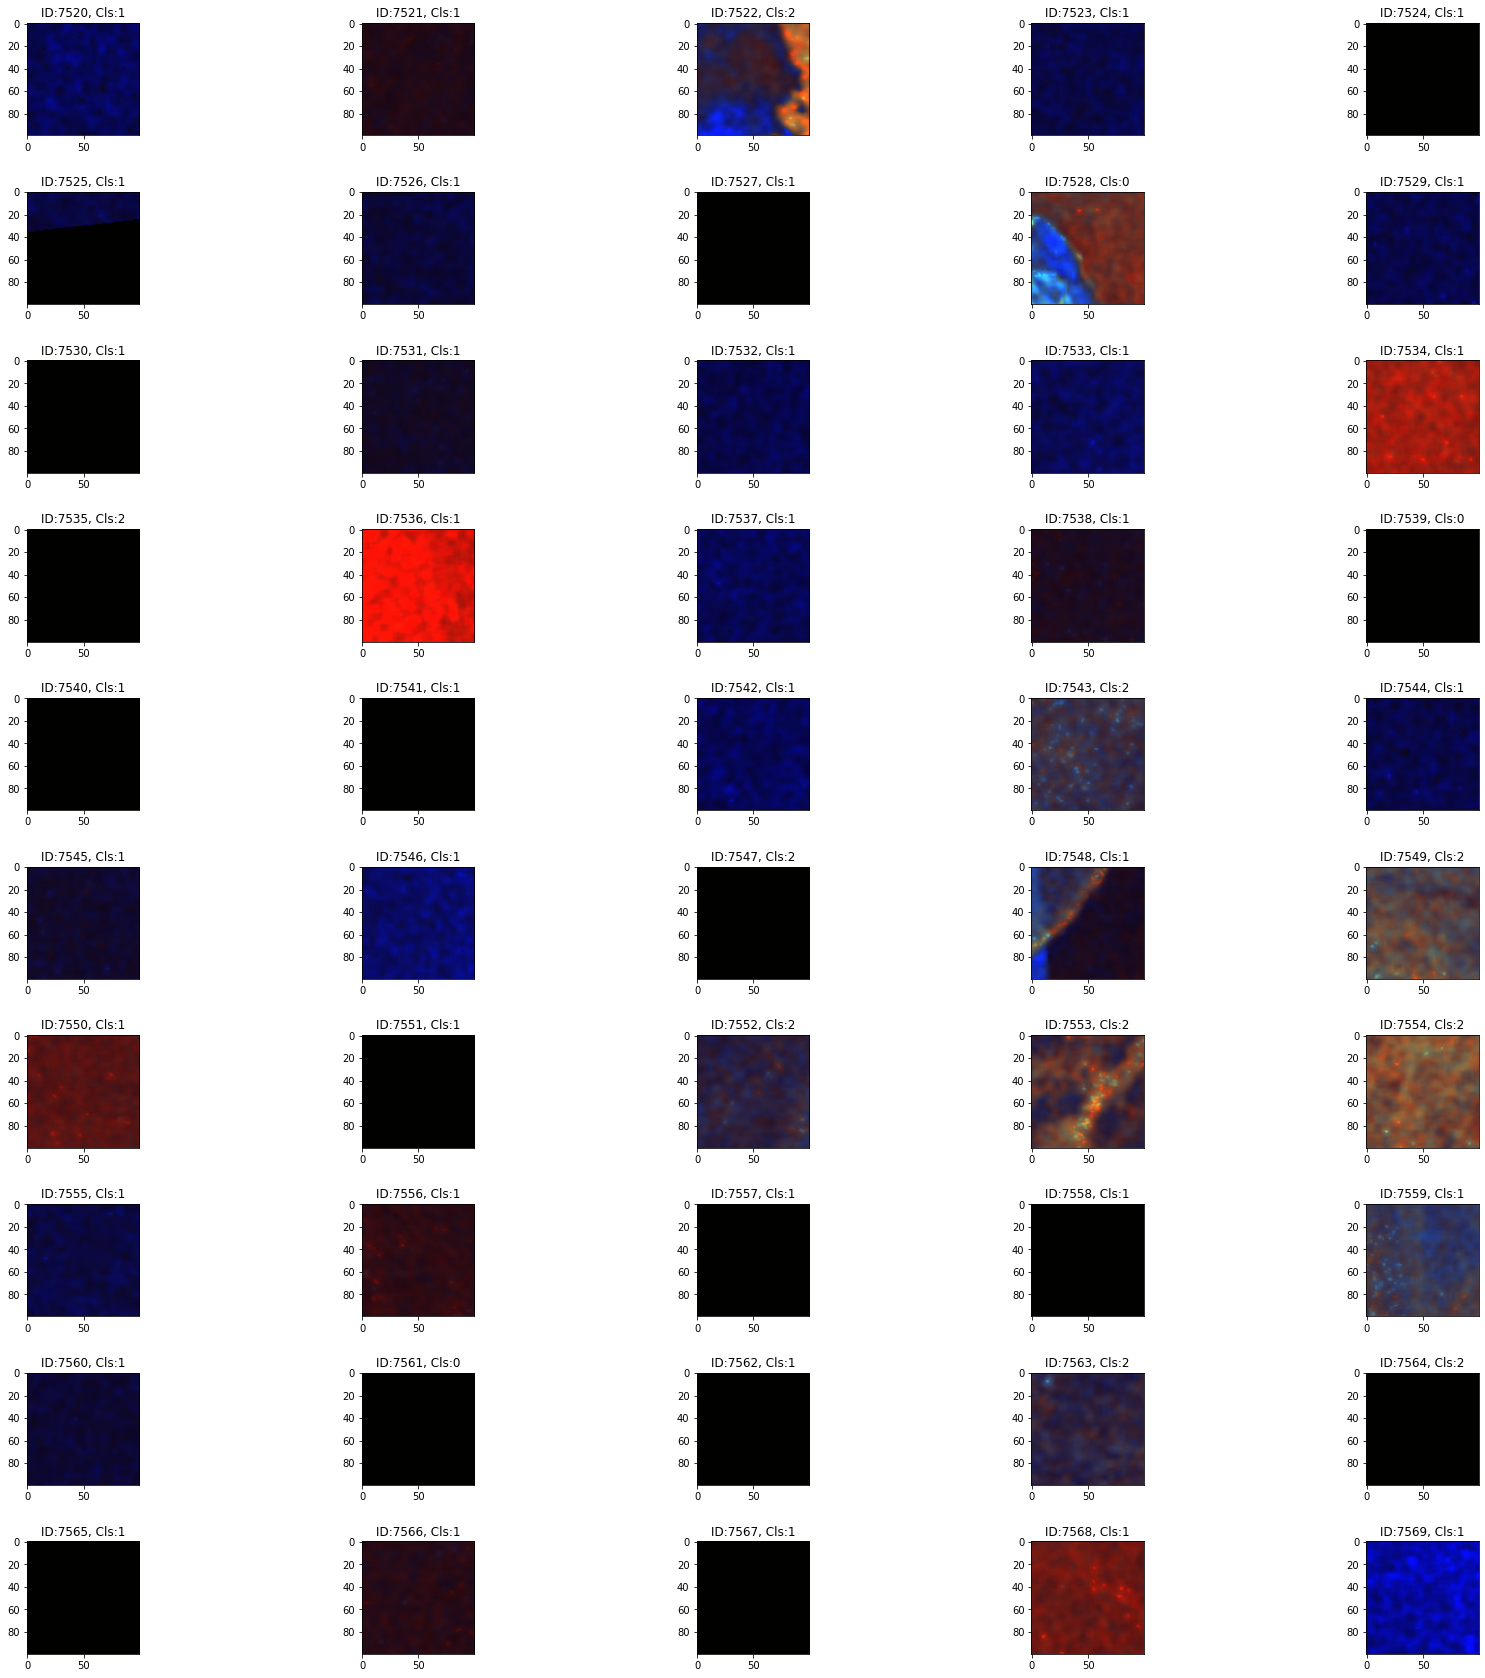

In [ ]:
## Data visualisation 
fig, axs = plt.subplots(10,5, figsize=(30, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(50):
    axs[i].imshow(x[i])
    axs[i].set_title('ID:{}, Cls:{}'.format(x_list[i],y[i]))


In [ ]:
## Splitting data into train and test
y=to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
print('Checking training dataset (x,y) shapes:',x_train.shape,y_train.shape)
print('Checking testing dataset (x,y) shapes:',x_test.shape,y_test.shape)

Checking training dataset (x,y) shapes: (5762, 100, 100, 3) (5762, 3)
Checking testing dataset (x,y) shapes: (641, 100, 100, 3) (641, 3)


In [ ]:
## Creating model
def modelling(model_id):

  ## Model 1 (CNN with 32 fileters in layer 1)
  if (model_id==1):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(200,200,3)))
    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax'))

  ## Model 2 (CNN with 64 fileters in layer 1)
  if (model_id==2):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100,3)))
    model.add(Conv2D(64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
  return model

In [ ]:
## Training model
nb_epoch=1
batch_size=64
model_id=2
model=modelling(model_id=model_id) # Change model ids to change models
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train,validation_data=(x_test, y_test), batch_size=batch_size,epochs=nb_epoch)
print('No: of iterations completed:',int((total_samples/batch_size)*nb_epoch))

91/91 [==============================] - 255s 3s/step - loss: 898.4007 - accuracy: 0.5433 - val_loss: 0.9179 - val_accuracy: 0.6958
No: of iterations completed: 100


In [ ]:
## Evaluation
print('Model outputs:',np.argmax(model.predict(x_test[:10]),axis=1))
print('Actual outputs:',np.argmax(y_test[0:10],axis=1))

Model outputs: [2 1 2 1 1 1 1 1 1 1]
Actual outputs: [2 1 2 2 1 1 1 1 1 2]


In [ ]:
print('No: smaples in test Class Land:',np.count_nonzero(np.argmax(y_test,axis=1) == 0),'(',round(np.count_nonzero(np.argmax(y_test,axis=1) == 0)/len(np.argmax(y_test,axis=1))*100,2),'%)')
print('No: smaples in test Class Water:',np.count_nonzero(np.argmax(y_test,axis=1)== 1),'(',round(np.count_nonzero(np.argmax(y_test,axis=1) == 1)/len(np.argmax(y_test,axis=1))*100,2),'%)')
print('No: smaples in test Class Ice:',np.count_nonzero(np.argmax(y_test,axis=1) == 2),'(',round(np.count_nonzero(np.argmax(y_test,axis=1) == 2)/len(np.argmax(y_test,axis=1))*100,2),'%)')

No: smaples in test Class Land: 54 ( 8.42 %)
No: smaples in test Class Water: 313 ( 48.83 %)
No: smaples in test Class Ice: 274 ( 42.75 %)


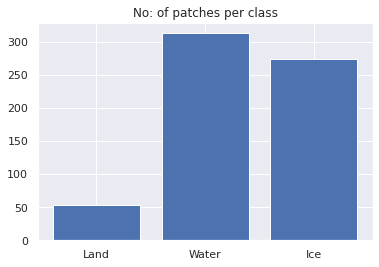

In [ ]:
plt.bar([0,1,2],[np.count_nonzero(np.argmax(y_test,axis=1) == 0),np.count_nonzero(np.argmax(y_test,axis=1) == 1),np.count_nonzero(np.argmax(y_test,axis=1) == 2)])
plt.xticks([0,1,2], ('Land', 'Water', 'Ice'))
plt.title('No: of patches per class')
plt.show()

[[  3  25  26]
 [  1 298  14]
 [  5 124 145]]


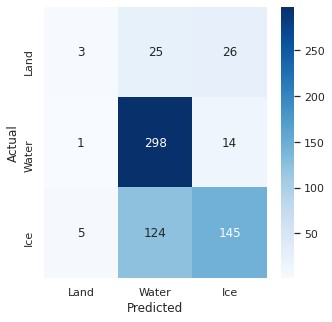

In [ ]:
## Confusion metrix
import seaborn as sn
y_true_labels = ["Land", "Water", "Ice"]
y_pred_labels = ["Land", "Water", "Ice"]
y_pred=np.argmax(model.predict(x_test),axis=1)
confusion_data =np.array(confusion_matrix(np.argmax(y_test,axis=1), y_pred),dtype=np.int32)
print(confusion_data)
df_cm = pd.DataFrame(confusion_data, columns=y_true_labels, index = y_true_labels)

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sn.set(font_scale=1)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12},fmt='g')# font size
plt.show()

In [ ]:
## Saving model
model.save(SAV_DIR+str(model_id))

## Restore model
reconstructed_model = keras.models.load_model(SAV_DIR+str(model_id))
reconstructed_model.summary()

## Checking:
np.testing.assert_allclose(model.predict(x_test),reconstructed_model.predict(x_test))

##
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PolarNet/2/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 589824)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               58982500  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 59,002,195
Trainable params: 59,002,195
Non-trainable params: 0
_________________________________________________________________
6/6 [===========================